Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: True
Selected Basins: ['501_Branna']

Training Basin 12815: 501_Branna
Total days with temperatures below zero (potential snow days) for 501_Branna: 2300

501_Branna - Basic Statistical Analysis on Unscaled Data:
Mean Temperature (T): 7.979843932891144
Mean Precipitation (P): 3.022294186500195
Mean Discharge (Q): 1.4596479906359734
Temperature Standard Deviation (T): 8.36514468946334
Precipitation Standard Deviation (P): 6.6003542464378055
Discharge Standard Deviation (Q): 1.556862280980219
Discharge Quantiles (Q):
0.25    0.756
0.50    1.072
0.75    1.694
Name: Q, dtype: float64


epoch,▁▁
lstm_train_loss,▁
transformer_train_loss,▁
epoch,0
lstm_train_loss,0.00227
transformer_train_loss,0.00431


Epoch 1/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 7.5672e-04
Epoch 2/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.2574e-04
Epoch 3/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.0980e-04
Epoch 4/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.1070e-04
Epoch 5/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.0821e-04
Epoch 6/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9955e-04
Epoch 7/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9856e-04
Epoch 8/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.0088e-04
Epoch 9/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.0052e-04
Epoch 10/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9931e-04
Epoch 11/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9532e-04
Epoch 12/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.9371e-04
Epoch 13/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.9028e-04
Epoch 14/100
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - l

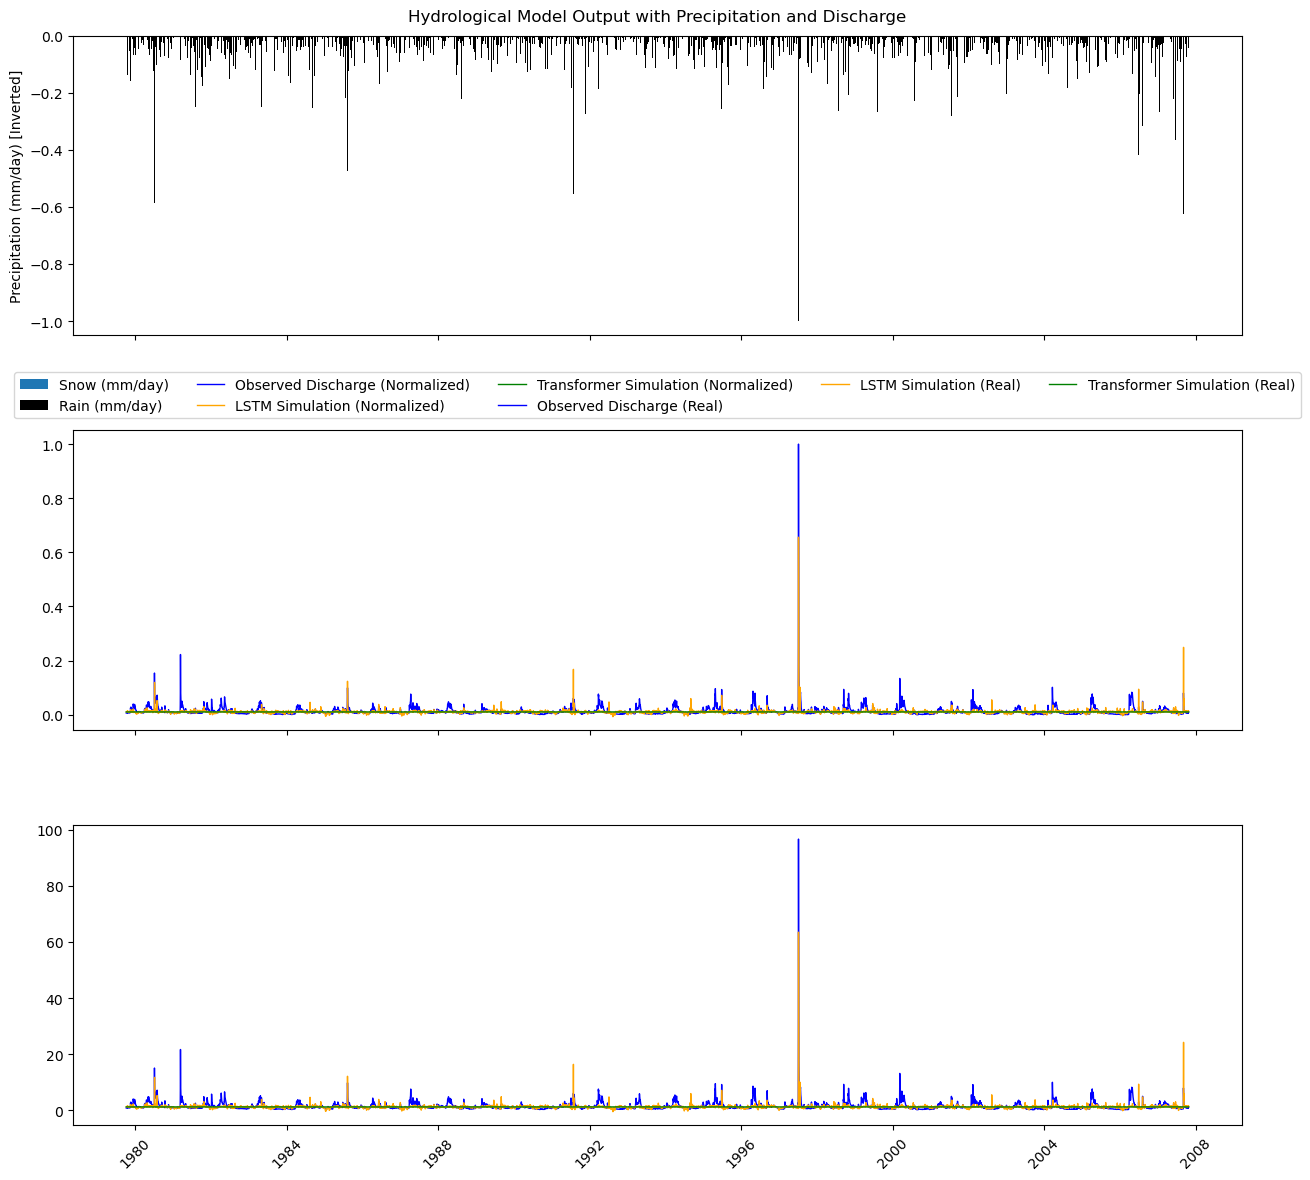

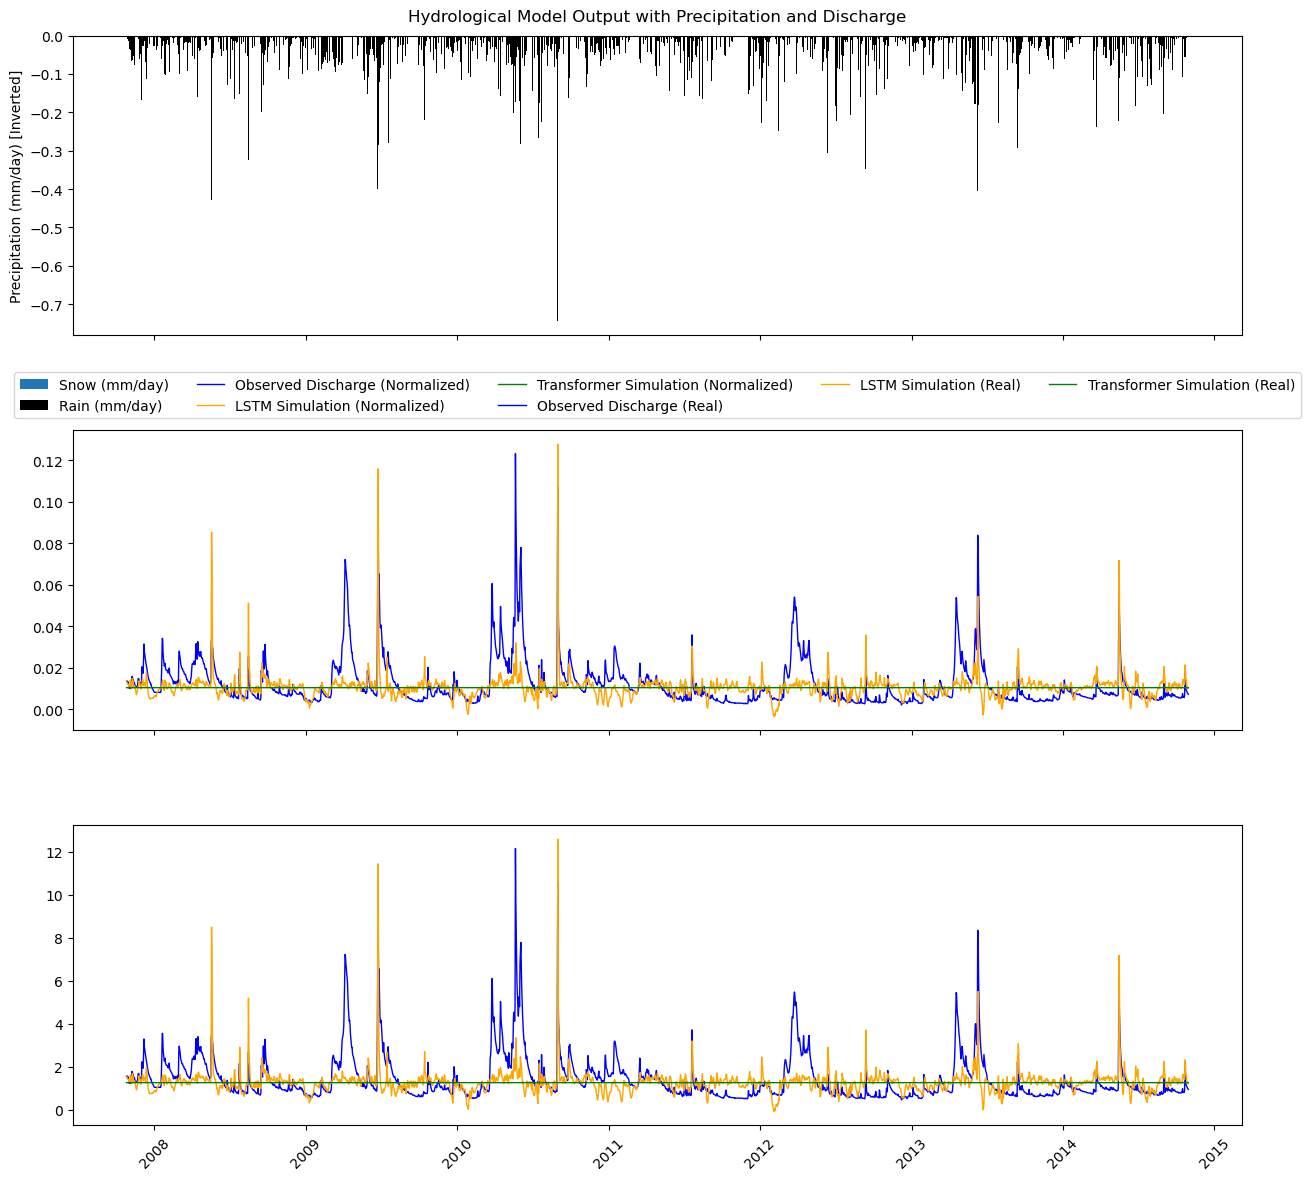

LSTM Model - Train MSE: 0.0001, Train RMSE: 0.0122, Train NSE: -0.3566
LSTM Model - Test MSE: 0.0001, Test RMSE: 0.0099, Test NSE: -0.2938
Transformer Model - Train MSE: 0.0003, Train RMSE: 0.0173, Train NSE: -0.0144
Transformer Model - Test MSE: 0.0001, Test RMSE: 0.0111, Test NSE: -0.0195


In [119]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import warnings
import wandb
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Define the function to calculate the NSE
def calculate_nse(observed, simulated):
    observed_mean = np.mean(observed)
    squared_errors = (observed - simulated) ** 2
    mse = np.mean(squared_errors)
    variance = np.mean((observed - observed_mean) ** 2)
    nse = 1 - (mse / variance)
    return nse

# List all available devices to confirm GPU is detected
devices = tf.config.list_physical_devices()
print("Available devices:", devices)
gpu_available = tf.config.list_physical_devices('GPU')
is_using_gpu = len(gpu_available) > 0
print(f'Using GPU: {is_using_gpu}')

data_dir = '/Users/doudou.ba/Downloads/dbstream'
csv_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.csv')]
basin_dataframes = [pd.read_csv(file_path, parse_dates=['Date'], index_col='Date') for file_path in csv_files]
data = pd.concat(basin_dataframes, axis=0)

basins = data['Basin'].unique()
selected_basins = random.sample(list(basins), 1)
print(f"Selected Basins: {selected_basins}")

data.loc[data['P'] < 0, 'P'] = np.nan
data.loc[data['Q'] < 0, 'Q'] = np.nan
data['P'].fillna(data['P'].mean(), inplace=True)
data['T'].fillna(data['T'].mean(), inplace=True)
data['Q'].fillna(data['Q'].mean(), inplace=True)

missing_values_P = data['P'].isnull()
missing_values_T = data['T'].isnull()
missing_values_Q = data['Q'].isnull()

data['P'][missing_values_P] = data['P'].mean()
data['T'][missing_values_T] = data['T'].mean()
data['Q'][missing_values_T] = data['Q'].mean()

def plot_results(basin_data, dates, observed_normalized, lstm_pred_normalized, transformer_pred_normalized, observed_real, lstm_pred_real, transformer_pred_real):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    tmin = basin_data['T'].values
    rain = basin_data['P'].values
    snow_days = tmin < 0
    adjusted_snow = np.where(snow_days, rain, 0)
    adjusted_rain = np.where(~snow_days, rain, 0)

    ax1.bar(dates[snow_days], -adjusted_snow[snow_days], width=2, color='cyan', label='Snow (mm/day)')
    ax1.bar(dates[~snow_days], -adjusted_rain[~snow_days], width=2, color='black', label='Rain (mm/day)')
    ax1.set_ylabel('Precipitation (mm/day) [Inverted]')

    ax2.plot(dates, observed_normalized, 'b-', linewidth=1, label='Observed Discharge (Normalized)')
    ax2.plot(dates, lstm_pred_normalized, 'orange', linewidth=1, label='LSTM Simulation (Normalized)')
    ax2.plot(dates, transformer_pred_normalized, 'green', linewidth=1, label='Transformer Simulation (Normalized)')

    ax3.plot(dates, observed_real, 'b-', linewidth=1, label='Observed Discharge (Real)')
    ax3.plot(dates, lstm_pred_real, 'orange', linewidth=1, label='LSTM Simulation (Real)')
    ax3.plot(dates, transformer_pred_real, 'green', linewidth=1, label='Transformer Simulation (Real)')

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
    plt.xticks(rotation=45)
    plt.suptitle('Hydrological Model Output with Precipitation and Discharge')
    plt.tight_layout()
    plt.show()

for selected_basin in selected_basins:
    print(f"\nTraining Basin {i+1}: {selected_basin}")
    basin_data = data[data['Basin'] == selected_basin].copy()

    snow_days_unscaled = basin_data['T'] < 0
    print(f"Total days with temperatures below zero (potential snow days) for {selected_basin}: {snow_days_unscaled.sum()}")

    print(f"\n{selected_basin} - Basic Statistical Analysis on Unscaled Data:")
    print(f"Mean Temperature (T): {basin_data['T'].mean()}")
    print(f"Mean Precipitation (P): {basin_data['P'].mean()}")
    print(f"Mean Discharge (Q): {basin_data['Q'].mean()}")
    print(f"Temperature Standard Deviation (T): {basin_data['T'].std()}")
    print(f"Precipitation Standard Deviation (P): {basin_data['P'].std()}")
    print(f"Discharge Standard Deviation (Q): {basin_data['Q'].std()}")
    print(f"Discharge Quantiles (Q):")
    print(basin_data['Q'].quantile([0.25, 0.5, 0.75]))

    features = ['P', 'T']
    scaler_features = MinMaxScaler()
    basin_data[features] = scaler_features.fit_transform(basin_data[features])

    scaler_q = MinMaxScaler()
    basin_q_values = basin_data['Q'].values.reshape(-1, 1)
    scaler_q.fit(basin_q_values)
    basin_data['Q'] = scaler_q.transform(basin_q_values).flatten()

seq_length = 30
X, y = [], []
for i in range(seq_length, len(basin_data)):
    X.append(basin_data.iloc[i - seq_length:i][features].values)
    y.append(basin_data.iloc[i]['Q'])
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

epoch_num = 10
batch_size_num = 320

wandb.init(project="phd_project")

train_dates = basin_data.iloc[seq_length - 1:len(X_train) + seq_length - 1].index
test_dates = basin_data.iloc[len(X_train) + seq_length - 1: len(X_train) + seq_length - 1 + len(X_test)].index

lstm_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(seq_length, len(features))),
    Dropout(0.2),
    Dense(32, activation='tanh'),
    Dropout(0.1),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
lstm_history = lstm_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_size_num, callbacks=[early_stopping])

wandb.log({"epoch": len(lstm_history.history['loss']), "lstm_train_loss": lstm_history.history['loss'][0]})

input_layer = Input(shape=(seq_length, len(features)))
x = LayerNormalization(epsilon=1e-6)(input_layer)
x = MultiHeadAttention(num_heads=2, key_dim=seq_length)(x, x, x)
x = Dropout(0.1)(x)
x = LayerNormalization(epsilon=1e-6)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
output_layer = Dense(1)(x)
transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
transformer_history = transformer_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_size_num, callbacks=[early_stopping])
wandb.log({"epoch": len(transformer_history.history['loss']), "transformer_train_loss": transformer_history.history['loss'][0]})

lstm_preds_train = lstm_model.predict(X_train)
transformer_preds_train = transformer_model.predict(X_train)
lstm_preds_test = lstm_model.predict(X_test)
transformer_preds_test = transformer_model.predict(X_test)

lstm_preds_train_scaled = scaler_q.inverse_transform(lstm_preds_train)
transformer_preds_train_scaled = scaler_q.inverse_transform(transformer_preds_train)
lstm_preds_test_scaled = scaler_q.inverse_transform(lstm_preds_test)
transformer_preds_test_scaled = scaler_q.inverse_transform(transformer_preds_test)

observed_real_train = scaler_q.inverse_transform(y_train.reshape(-1, 1)).flatten()
observed_real_test = scaler_q.inverse_transform(y_test.reshape(-1, 1)).flatten()

plot_results(
    basin_data.iloc[seq_length - 1:len(X_train) + seq_length - 1],
    train_dates,
    y_train,
    lstm_preds_train.flatten(),
    transformer_preds_train.flatten(),
    observed_real_train,
    lstm_preds_train_scaled.flatten(),
    transformer_preds_train_scaled.flatten()
)

plot_results(
    basin_data.iloc[len(X_train) + seq_length - 1: len(X_train) + seq_length - 1 + len(X_test)],
    test_dates,
    y_test,
    lstm_preds_test.flatten(),
    transformer_preds_test.flatten(),
    observed_real_test,
    lstm_preds_test_scaled.flatten(),
    transformer_preds_test_scaled.flatten()
)

lstm_train_mse = mean_squared_error(y_train, lstm_preds_train)
lstm_test_mse = mean_squared_error(y_test, lstm_preds_test)
lstm_train_rmse = np.sqrt(lstm_train_mse)
lstm_test_rmse = np.sqrt(lstm_test_mse)
lstm_train_nse = calculate_nse(y_train, lstm_preds_train)
lstm_test_nse = calculate_nse(y_test, lstm_preds_test)

print(f"LSTM Model - Train MSE: {lstm_train_mse:.4f}, Train RMSE: {lstm_train_rmse:.4f}, Train NSE: {lstm_train_nse:.4f}")
print(f"LSTM Model - Test MSE: {lstm_test_mse:.4f}, Test RMSE: {lstm_test_rmse:.4f}, Test NSE: {lstm_test_nse:.4f}")

transformer_train_mse = mean_squared_error(y_train, transformer_preds_train)
transformer_test_mse = mean_squared_error(y_test, transformer_preds_test)
transformer_train_rmse = np.sqrt(transformer_train_mse)
transformer_test_rmse = np.sqrt(transformer_test_mse)
transformer_train_nse = calculate_nse(y_train, transformer_preds_train)
transformer_test_nse = calculate_nse(y_test, transformer_preds_test)

print(f"Transformer Model - Train MSE: {transformer_train_mse:.4f}, Train RMSE: {transformer_train_rmse:.4f}, Train NSE: {transformer_train_nse:.4f}")
print(f"Transformer Model - Test MSE: {transformer_test_mse:.4f}, Test RMSE: {transformer_test_rmse:.4f}, Test NSE: {transformer_test_nse:.4f}")
